In [ ]:
import sys
import os

sys.path.append(os.path.abspath("C:/Users/seyf/Documents/GitHub/Master-Thesis/code"))

from utils import filter_labels_with_threshold
from models_prediction_utils import predict_HuggingFace_models, predict_citizenlab_model

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

c:\Users\seyf\anaconda3\envs\thesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Paths
samples_file_path = "Wikipedia attack/Wikipedia_attack_annotated_comments.tsv"
annotations_file_path = "Wikipedia attack/Wikipedia_attack_annotations.tsv"

# Loading files into DataFrames
samples = pd.read_csv(samples_file_path, sep='\t')
annotations = pd.read_csv(annotations_file_path, sep='\t')

# Selecting necessary columns from the loaded DataFrames
test_samples = samples[['rev_id', 'comment']]
test_labels = annotations[['rev_id','attack']]

# Display the first few rows
# display(samples.head())
# display(annotations.head())

The data contains several annotation (from different annotatators). I decided to define a threshold and if the percentage of 'attack' annotations is higher or equal to this threshold then the sample is annotated as 'attack'.

TODO: plot a graph for different values of the threshold

In [3]:
# Step 1: Filter out rows in `test_labels` where `attack` is -1 
# Keep only samples with available labels
filtered_test_labels = test_labels[test_labels['attack'].isin([0.0, 1.0])]

# Step 1: Apply filtering strategy with threshold (e.g., 0.6 means 60% of the annotations must agree, default is 0.0)
filtered_test_labels_threshold = filter_labels_with_threshold(filtered_test_labels, threshold=0.5)

# Step 2: Match the rev_id
valid_ids_threshold = filtered_test_labels_threshold['rev_id']
filtered_test_threshold = test_samples[test_samples['rev_id'].isin(valid_ids_threshold)]


samples = filtered_test_threshold['comment']
labels = filtered_test_labels_threshold['attack']

# Replace NaN values with an empty string
samples = test_samples['comment'].fillna('')
# Convert all entries to string
samples = samples.astype(str)
# Remove control characters
samples = samples.apply(lambda x: ''.join(c for c in x if c.isprintable()))
# Lowercase and remove leading/trailing whitespaces
samples = samples.apply(lambda x: x.lower().strip())

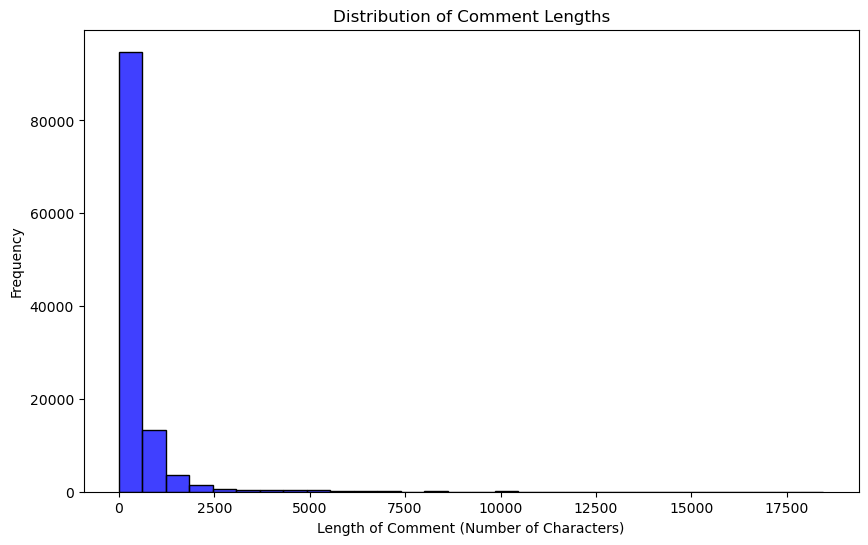

In [4]:
# Calculate the length of each string in the 'samples' list
lengths = samples.apply(len)

# Create a histogram
plt.figure(figsize=(10, 6))
sns.histplot(lengths, kde=False, bins=30, color='blue')  # Adjust bins as needed
plt.title('Distribution of Comment Lengths')
plt.xlabel('Length of Comment (Number of Characters)')
plt.ylabel('Frequency')

# Display the plot
plt.show()

In [5]:
# test set size is 115864, computation time too long on my computer
# test_set_size = 115864
NB_SAMPLE = 500

# Maximum length of a tokens
MAX_LENGTH = 200

# EthicalEye

In [6]:
# autopilot-ai/EthicalEye
EthicalEye_model = AutoModelForSequenceClassification.from_pretrained("autopilot-ai/EthicalEye")
EthicalEye_tokenizer = AutoTokenizer.from_pretrained("autopilot-ai/EthicalEye")

In [7]:
EthicalEye_predictions_df = predict_HuggingFace_models("EthicalEye", EthicalEye_model, EthicalEye_tokenizer, samples, NB_SAMPLE, MAX_LENGTH)

display(EthicalEye_predictions_df)

,comment,non_safe_probability
0,`-newline_tokenthis is not ``creative``. thos...,0.026146
1,`newline_tokennewline_token:: the term ``stand...,0.007542
2,"newline_tokennewline_tokentrue or false, the s...",0.002100
3,"next, maybe you could work on being less conde...",0.929448
4,this page will need disambiguation.,0.000170
...,...,...
495,`::::::::a cheap excuse: ``quality`` is what p...,0.010677
496,one more thing- was there ever actually a vote...,0.000644
497,newline_token:::how in perun's sake he could h...,0.084108
498,newline_token:if you can find accurate numbers...,0.000218


# KoalaAI/TextClassification

In [8]:
# Load the model and tokenizer
KoalaAI_model = AutoModelForSequenceClassification.from_pretrained("KoalaAI/Text-Moderation")
KoalaAI_tokenizer = AutoTokenizer.from_pretrained("KoalaAI/Text-Moderation")

In [9]:
KoalaAI_predictions_df = predict_HuggingFace_models("KoalaAI", KoalaAI_model, KoalaAI_tokenizer, samples, NB_SAMPLE, MAX_LENGTH)

# Print the DataFrame
display(KoalaAI_predictions_df)


,comment,non_safe_probability
0,`-newline_tokenthis is not ``creative``. thos...,0.006348
1,`newline_tokennewline_token:: the term ``stand...,0.002227
2,"newline_tokennewline_tokentrue or false, the s...",0.003852
3,"next, maybe you could work on being less conde...",0.002053
4,this page will need disambiguation.,0.002997
...,...,...
495,`::::::::a cheap excuse: ``quality`` is what p...,0.003577
496,one more thing- was there ever actually a vote...,0.002288
497,newline_token:::how in perun's sake he could h...,0.002535
498,newline_token:if you can find accurate numbers...,0.001665


# citizenlab/distilbert-base-multilingual-cased-toxicity 

In [10]:
# citizenlab/distilbert-base-multilingual-cased-toxicity 
citizenlab_model_path = "citizenlab/distilbert-base-multilingual-cased-toxicity"
citizenlab_toxicity_classifier = pipeline("text-classification", model=citizenlab_model_path, tokenizer=citizenlab_model_path)

In [11]:
citizenlab_predictions_df = predict_citizenlab_model(citizenlab_toxicity_classifier, samples, NB_SAMPLE, MAX_LENGTH)

# Print the DataFrame
display(citizenlab_predictions_df)

,comment,non_safe_probability
0,`-newline_tokenthis is not ``creative``. thos...,0.004266
1,`newline_tokennewline_token:: the term ``stand...,0.001312
2,"newline_tokennewline_tokentrue or false, the s...",0.001990
3,"next, maybe you could work on being less conde...",0.276436
4,this page will need disambiguation.,0.001082
...,...,...
495,`::::::::a cheap excuse: ``quality`` is what p...,0.016009
496,one more thing- was there ever actually a vote...,0.002999
497,newline_token:::how in perun's sake he could h...,0.037807
498,newline_token:if you can find accurate numbers...,0.000938


# ROC curve plot + AUC score
Comparing ROC and AUC for every model on Kaggle Toxic Comment Challenge dataset.

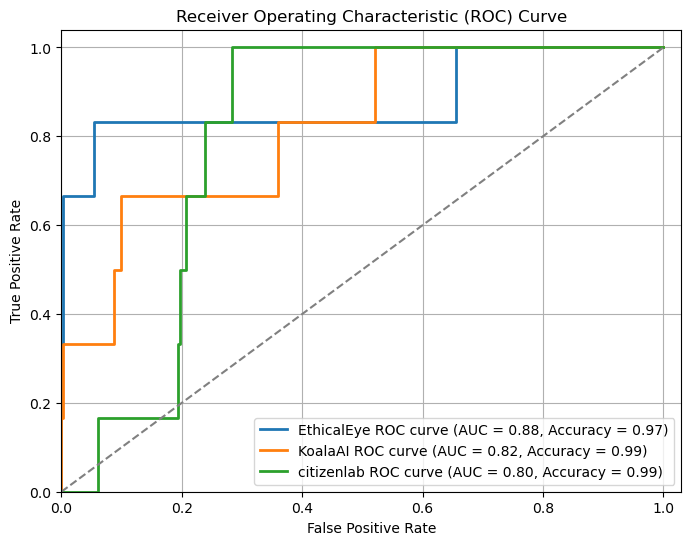


Model Performance Metrics:

|    | Model      |      AUC |   Accuracy |
|---:|:-----------|---------:|-----------:|
|  0 | EthicalEye | 0.880904 |      0.968 |
|  1 | KoalaAI    | 0.821862 |      0.99  |
|  2 | citizenlab | 0.803306 |      0.988 |


In [14]:
# y_true should be a 1D array of true binary labels (0 or 1)
y_true = labels[:NB_SAMPLE]  # ground truth labels

# Threshold to classify probabilities as positive (1) or negative (0)
threshold = 0.5

# Dictionary to store model names and their predictions
models_predictions = {
    'EthicalEye': EthicalEye_predictions_df['non_safe_probability'],
    'KoalaAI': KoalaAI_predictions_df['non_safe_probability'],
    'citizenlab': citizenlab_predictions_df['non_safe_probability']
    # Add more models here if needed
}

# Data structure to store metrics for each model
metrics_data = []

# Initialize plot
plt.figure(figsize=(8, 6))

# Loop over each model and compute ROC and AUC
for model_name, y_pred in models_predictions.items():
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Calculate binary predictions using the threshold
    y_pred_binary = (y_pred >= threshold).astype(int)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred_binary)

    # Store the metrics in a dictionary
    metrics_data.append({
        'Model': model_name,
        'AUC': roc_auc,
        'Accuracy': accuracy
    })
    
    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} ROC curve (AUC = {roc_auc:.2f}, Accuracy = {accuracy:.2f})')

# Plot the diagonal line (random guess)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Configure plot
plt.xlim([0.0, 1.03])
plt.ylim([0.0, 1.04])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Create a DataFrame from the collected metrics data
metrics_df = pd.DataFrame(metrics_data)

# Display the table of metrics
print("\nModel Performance Metrics:\n")
print(metrics_df.to_markdown())